# Emotion-Recognition Kaggle Model V6

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input
from sklearn.metrics import confusion_matrix
import random
import glob
import itertools
import os
import shutil
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Classses Distribution
print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../datasets/kaggle_dataset_train/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()

Dataset Classes Distribution
📁 /
├─📁 angry/
│ └─0 folder(s), 3595 file(s)
├─📁 disgust/
│ └─0 folder(s), 393 file(s)
├─📁 fear/
│ └─0 folder(s), 3688 file(s)
├─📁 happy/
│ └─0 folder(s), 6493 file(s)
├─📁 neutral/
│ └─0 folder(s), 4469 file(s)
├─📁 sad/
│ └─0 folder(s), 4347 file(s)
└─📁 surprise/
  └─0 folder(s), 2854 file(s)


In [3]:
# I create a different folder for the validation set
os.chdir('../datasets/')
if os.path.isdir('kaggle_dataset_validate/') is False:
    os.makedirs('kaggle_dataset_validate/angry')
    os.makedirs('kaggle_dataset_validate/disgust')
    os.makedirs('kaggle_dataset_validate/fear')
    os.makedirs('kaggle_dataset_validate/happy')
    os.makedirs('kaggle_dataset_validate/neutral')
    os.makedirs('kaggle_dataset_validate/sad')
    os.makedirs('kaggle_dataset_validate/surprise')

    # Now I move 10% of random images from each train class to the proper validation set
    for i in random.sample(glob.glob('kaggle_dataset_train/angry/*'), 399):
        shutil.move(i, 'kaggle_dataset_validate/angry')        
    for i in random.sample(glob.glob('kaggle_dataset_train/disgust/*'), 43):
        shutil.move(i, 'kaggle_dataset_validate/disgust')
    for i in random.sample(glob.glob('kaggle_dataset_train/fear/*'), 409):
        shutil.move(i, 'kaggle_dataset_validate/fear')
    for i in random.sample(glob.glob('kaggle_dataset_train/happy/*'), 721):
        shutil.move(i, 'kaggle_dataset_validate/happy')
    for i in random.sample(glob.glob('kaggle_dataset_train/neutral/*'), 496):
        shutil.move(i, 'kaggle_dataset_validate/neutral')
    for i in random.sample(glob.glob('kaggle_dataset_train/sad/*'), 483):
        shutil.move(i, 'kaggle_dataset_validate/sad')
    for i in random.sample(glob.glob('kaggle_dataset_train/surprise/*'), 317):
        shutil.move(i, 'kaggle_dataset_validate/surprise')


os.chdir('../notebooks')

In [4]:
# Process the data
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define sets
# Since the tesing set has more data than the created validate, we will use test as validate and validate as test
training_path = '../datasets/kaggle_dataset_train/'
valididation_path = '../datasets/kaggle_dataset_test/'
testing_path = '../datasets/kaggle_dataset_validate/'

Num GPUs Available:  1


In [5]:
# Now we use Keras's ImageDataGenerator class to create batches of data from the training, validation and testing sets
train_batches = ImageDataGenerator().flow_from_directory(directory=training_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valididation_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(directory=testing_path, target_size=(48,48), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], color_mode="grayscale", batch_size=32, shuffle=False)

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2867 images belonging to 7 classes.


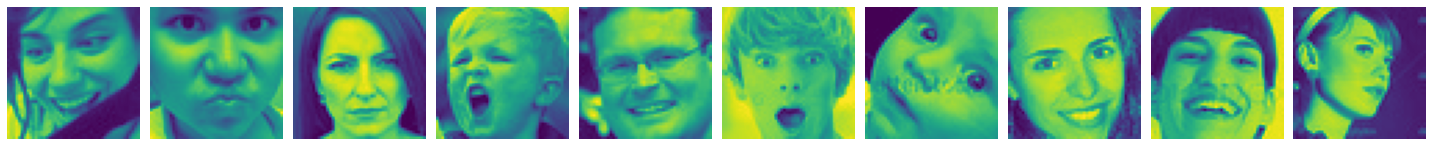

[[0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [6]:
imgs, labels = next(train_batches)

# Plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.
# The classes are represented with the one-hot encoding , for example 'angry' is [1. 0. 0. 0. 0. 0. 0.]

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [7]:
# I will try something a more complex now
model = Sequential()

# Convolutional Layer N.1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())

# Now we create the first fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Now we create the second fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Now we create the output [7 is the number of classes]
# We use softmax since it's for multi-classification
model.add(Dense(7, activation="softmax"))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

The model itself is very simple, we have an input layer that takes images images that are 48 by 48 with only 1 channel (grayscale), the we have 2 hidden layers each followed by maxpooling in order to reduce the dimension. We also enable zero-padding by specifying padding = 'same'.
The output layer has 7 outputs each for each emotion class. Again, very simple, then later I will make it more complex or maybe use as base another trained model.

In [9]:
# Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric.

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

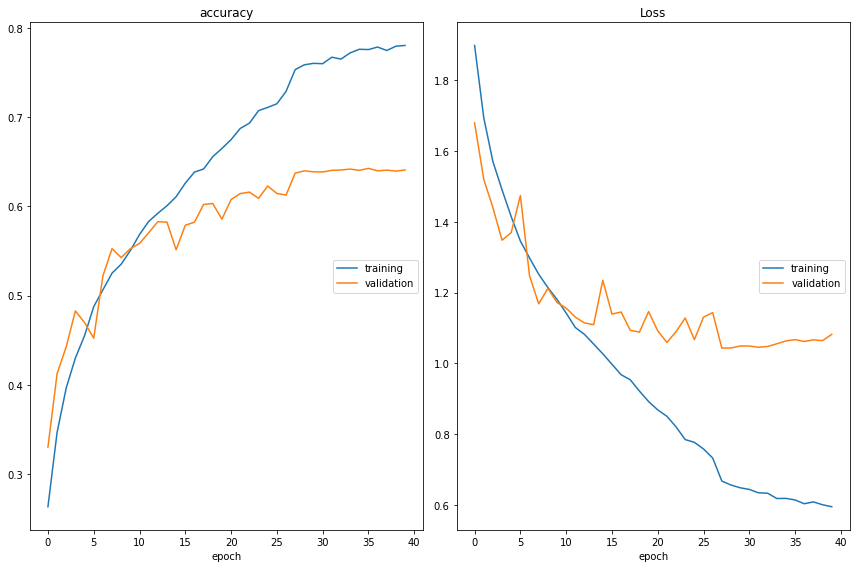

accuracy
	training         	 (min:    0.263, max:    0.780, cur:    0.780)
	validation       	 (min:    0.330, max:    0.643, cur:    0.641)
Loss
	training         	 (min:    0.595, max:    1.899, cur:    0.595)
	validation       	 (min:    1.043, max:    1.680, cur:    1.082)

Epoch 00040: val_accuracy did not improve from 0.64252


In [10]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto', min_lr=0.00001, cooldown=0)

model_checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, save_best_only=True, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF(), model_checkpoint, reduce_learning_rate]

# Now I will train the model using 
model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=40,
    callbacks=callbacks
)

By creating a more complex model I got more overfitting and a lower performance on the training set.

Confusion matrix, without normalization
[[205   9  23  24  67  61  10]
 [  7  26   1   1   1   7   0]
 [ 34   2 155  29  52  84  53]
 [  9   1  12 621  43  23  12]
 [ 27   1  18  39 332  74   5]
 [ 37   2  34  29 107 271   3]
 [  8   0  34  16  15  10 233]]


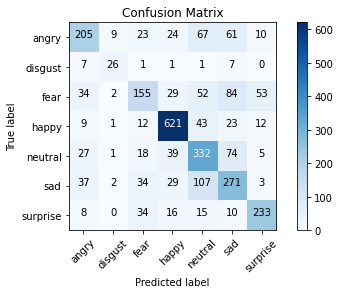

In [11]:
#Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we'll plot them in a confusion matrix

test_imgs, test_labels = next(test_batches)
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Strangely, this model performs better on new data than v5, even if the training accuracy was only 78%.

In [12]:
# I will save anyways the model for the archive
model.save("kaggle_model_v6.h5")